In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd /content/drive/MyDrive/hate_speech/models

/content/drive/MyDrive/hate_speech/models


In [3]:
! pip install transformers==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 37.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 89.2 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=906a572f39d3e4c0c16775f38e982736a1b23fe3890a5da9cb481a3b7dbd8271
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


In [4]:
import torch.nn as nn
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import time
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
     

In [5]:
# Set the seed value all over the place to make this reproducible.
seed_val = 1234

random.seed(seed_val)
torch.manual_seed(seed_val)

In [6]:
# build the model
class LSTM(nn.Module):
  def __init__(self,vocab_size, emb_size, lstm_size, num_label):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_size)
    self.lstm = nn.LSTM(emb_size, lstm_size, bidirectional=True, batch_first=True)
    self.linear = nn.Linear(lstm_size*2, num_label)

  def forward(self, input): # input.shape: (batch_size, texts_length)
    emb = self.emb(input) # (batch_size, texts_length, emb_size)
    lstm, _ = self.lstm(emb)  # (batch_size, texts_length, lstm_size*2)
    lstm = torch.max(lstm, dim=1).values # max pooling, (batch_size, lstm_size*2)
    output = self.linear(lstm) # (batch_size, num_label)
    return output

In [7]:
def do_tokenize(csv, tokenizer, device):
    '''
    run the tokenizer, pad the sequence
    returns: a dataset containing input_ids, attention_masks, labels
    '''
    tweets = csv.tweet.values
    labels = csv.label.values
    # calculate max length of the tweets
    max_length = 0
    for t in tweets:
        ids = tokenizer.encode(t)
        max_length = max(len(ids),max_length)
    # get input ids and attention_masks of the tokens
    input_ids = []
    attention_masks = []
    for t in tweets:
        input_dict = tokenizer.encode_plus(t, add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
        input_ids.append(input_dict['input_ids'])
        attention_masks.append(input_dict['attention_mask'])
    input_ids = torch.cat(input_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    labels = torch.tensor(labels)
    return input_ids.to(device), attention_masks.to(device), labels.to(device)
    #return TensorDataset(input_ids.to(device), attention_masks.to(device), labels.to(device))
    

In [8]:
def calculate_acc(output, labels):
    preds = torch.argmax(output, dim=1)
    return torch.eq(labels, preds).sum().item() / labels.size(0)

In [9]:
def train(model, iterator, optimizer, criterion):
    train_loss = 0
    train_acc = 0
    model.train()
    for input_ids, _, labels in tqdm(iterator):
        output = model(input_ids)
        acc = calculate_acc(output, labels)
        model.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += acc
    return train_loss / len(iterator), train_acc / len(iterator)

In [10]:
def evaluate(model, iterator, criterion):
    eval_loss = 0
    eval_acc = 0
    model.eval()
    with torch.no_grad():
        for input_ids, _, labels in tqdm(iterator):
            output = model(input_ids)
            loss = criterion(output, labels)
            acc = calculate_acc(output, labels)
            eval_loss += loss.item()
            eval_acc += acc
    return eval_loss / len(iterator), eval_acc / len(iterator)

In [11]:
EPOCHS = 10
BATCH_SIZE = 64
EMB_SIZE = 128
LSTM_SIZE = 128
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [13]:
train_csv = pd.read_csv('../data/Davidson/train.csv', names=['label','tweet'],header=0)
dev_csv = pd.read_csv('../data/Davidson/dev.csv', names=['label','tweet'], header=0)
train_inputs, train_mask, train_labels = do_tokenize(train_csv, tokenizer, DEVICE)
dev_inputs, dev_mask, dev_labels = do_tokenize(dev_csv, tokenizer, DEVICE)
train_dataset = TensorDataset(train_inputs, train_mask, train_labels)
dev_dataset = TensorDataset(dev_inputs, dev_mask, dev_labels)
train_loader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = BATCH_SIZE)
dev_loader = DataLoader(dev_dataset, sampler = SequentialSampler(dev_dataset), batch_size = BATCH_SIZE)

In [14]:
model = LSTM(tokenizer.vocab_size, EMB_SIZE, LSTM_SIZE, 3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [15]:
best_dev_acc = 0
best_epoch = 0
print(f'Start training...')
train_accs, dev_accs, train_losses, dev_losses = [], [],[], []
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    dev_loss, dev_acc = evaluate(model, dev_loader, criterion)
    train_accs.append(train_acc)
    dev_accs.append(dev_acc)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    print(f'Epoch {epoch + 1}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
    print(f'Epoch {epoch + 1}: dev loss: {dev_loss:.4f}, dev acc: {dev_acc:.4f}')
    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        best_epoch = epoch + 1
        torch.save(model, "LSTM.model")
        print(f'*** Epoch {epoch + 1}: dev acc higher than best dev acc, model saved!')
sec = time.time()-start_time
print(f'Training finished! Best epoch is {best_epoch}, best dev acc is {best_dev_acc:.4f}, {sec} seconds used.')

Start training...


100%|██████████| 39/39 [00:00<00:00, 153.86it/s]


Epoch 1: train loss: 0.4003, train acc: 0.8528
Epoch 1: dev loss: 0.2834, dev acc: 0.8980
*** Epoch 1: dev acc higher than best dev acc, model saved!


100%|██████████| 39/39 [00:00<00:00, 149.37it/s]


Epoch 2: train loss: 0.2531, train acc: 0.9115
Epoch 2: dev loss: 0.2639, dev acc: 0.9095
*** Epoch 2: dev acc higher than best dev acc, model saved!


100%|██████████| 39/39 [00:00<00:00, 149.99it/s]


Epoch 3: train loss: 0.2063, train acc: 0.9270
Epoch 3: dev loss: 0.2673, dev acc: 0.9087


100%|██████████| 39/39 [00:00<00:00, 148.63it/s]


Epoch 4: train loss: 0.1586, train acc: 0.9440
Epoch 4: dev loss: 0.3010, dev acc: 0.9040


100%|██████████| 39/39 [00:00<00:00, 144.93it/s]


Epoch 5: train loss: 0.1088, train acc: 0.9640
Epoch 5: dev loss: 0.3157, dev acc: 0.9042


100%|██████████| 39/39 [00:00<00:00, 133.65it/s]


Epoch 6: train loss: 0.0626, train acc: 0.9801
Epoch 6: dev loss: 0.3807, dev acc: 0.8916


100%|██████████| 39/39 [00:00<00:00, 145.59it/s]


Epoch 7: train loss: 0.0339, train acc: 0.9908
Epoch 7: dev loss: 0.4177, dev acc: 0.8856


100%|██████████| 39/39 [00:00<00:00, 145.69it/s]


Epoch 8: train loss: 0.0182, train acc: 0.9960
Epoch 8: dev loss: 0.4918, dev acc: 0.8946


100%|██████████| 39/39 [00:00<00:00, 143.41it/s]


Epoch 9: train loss: 0.0150, train acc: 0.9965
Epoch 9: dev loss: 0.4627, dev acc: 0.8918


100%|██████████| 39/39 [00:00<00:00, 146.19it/s]

Epoch 10: train loss: 0.0103, train acc: 0.9981
Epoch 10: dev loss: 0.5317, dev acc: 0.8926
Training finished! Best epoch is 2, best dev acc is 0.9095, 9.701228141784668 seconds used.


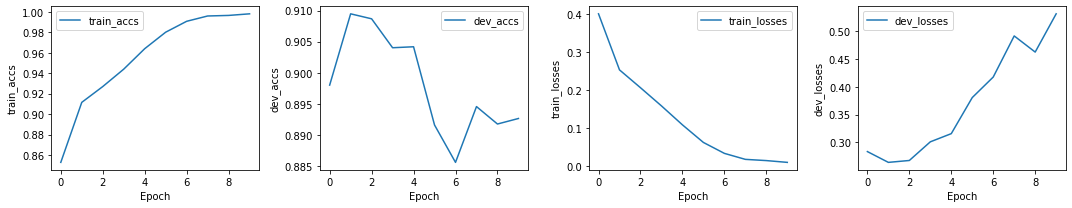

In [16]:
results = dict()
results["train_accs"] = train_accs
results["dev_accs"] = dev_accs
results["train_losses"] = train_losses
results["dev_losses"] = dev_losses
fig, plots = plt.subplots(ncols=4, figsize=(15,3))
for (category, result), plot in zip(results.items(), plots.flatten()):
  plot.plot(result, label=category)
  plot.set_xlabel('Epoch')
  plot.set_ylabel(category)
  plot.legend()
fig.tight_layout()

# test the model

In [17]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.12418301 0.75163399 0.12418301]
 [0.0046729  0.96469367 0.03063344]
 [0.0075     0.0475     0.945     ]]


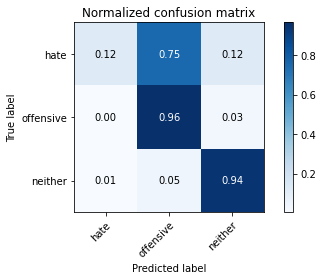

In [19]:
# test the final model with test file
test_csv = pd.read_csv('../data/Davidson/test.csv', names=['label','tweet'], header=0)
test_dataset = do_tokenize(test_csv, tokenizer, DEVICE)
best_model = torch.load("LSTM.model", map_location=DEVICE)
best_model.eval()
with torch.no_grad():
    input_ids, _, labels = test_dataset
    output = best_model(input_ids)
    loss = criterion(output, labels)
    preds = torch.argmax(output, dim=1)
plot_confusion_matrix(labels.cpu(), preds.cpu(), classes = ["hate","offensive","neither"], normalize=True,title='Normalized confusion matrix')

In [20]:
print(classification_report(labels.cpu(), preds.cpu(), target_names=["hate","offensive","neither"]))

              precision    recall  f1-score   support

        hate       0.61      0.12      0.21       153
   offensive       0.93      0.96      0.95      1926
     neither       0.83      0.94      0.88       400

    accuracy                           0.91      2479
   macro avg       0.79      0.68      0.68      2479
weighted avg       0.90      0.91      0.89      2479

